<a href="https://colab.research.google.com/github/riccardorampon/LANL-Earthquake-Prediction/blob/main/Earthquake_Acustic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#to access kaggle datasets
!pip install kaggle
#Math operations
!pip install numpy
#Machine learning
!pip install catboost

     |████████████████████████████████| 76.6 MB 42 kB/s 


In [2]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt

In [3]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [4]:
#list competitions
!kaggle competitions list

ref                                                       deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
mpetitions/contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         38           False  
mpetitions/gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        136           False  
mpetitions/store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge       1326           False  
mpetitions/tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        177           False  
mpetitions/digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2115           False  
mpetitions/titanic                                     

In [5]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

100% 2.27G/2.27G [00:13<00:00, 199MB/s]
100% 2.27G/2.27G [00:13<00:00, 179MB/s]


In [6]:
#unzip training data for usage, will take about 5 minutes (its big)
!unzip LANL-Earthquake-Prediction.zip


Archive:  LANL-Earthquake-Prediction.zip
  inflating: sample_submission.csv   
  inflating: test/seg_00030f.csv     
  inflating: test/seg_0012b5.csv     
  inflating: test/seg_00184e.csv     
  inflating: test/seg_003339.csv     
  inflating: test/seg_0042cc.csv     
  inflating: test/seg_004314.csv     
  inflating: test/seg_004cd2.csv     
  inflating: test/seg_004ee5.csv     
  inflating: test/seg_004f1f.csv     
  inflating: test/seg_00648a.csv     
  inflating: test/seg_006e4a.csv     
  inflating: test/seg_007a37.csv     
  inflating: test/seg_00a37e.csv     
  inflating: test/seg_00be11.csv     
  inflating: test/seg_00c35b.csv     
  inflating: test/seg_00cc91.csv     
  inflating: test/seg_00e5f7.csv     
  inflating: test/seg_00f3b9.csv     
  inflating: test/seg_010eab.csv     
  inflating: test/seg_0125d9.csv     
  inflating: test/seg_0144cb.csv     
  inflating: test/seg_0165c6.csv     
  inflating: test/seg_016913.csv     
  inflating: test/seg_016cdb.csv     
  inflati

In [7]:
#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [8]:
# pandas doesn't show us all the decimals
pd.options.display.precision = 15

In [9]:
#print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788
5,8,1.4690999777
6,9,1.4690999766
7,7,1.4690999755
8,-5,1.4690999744
9,3,1.4690999733


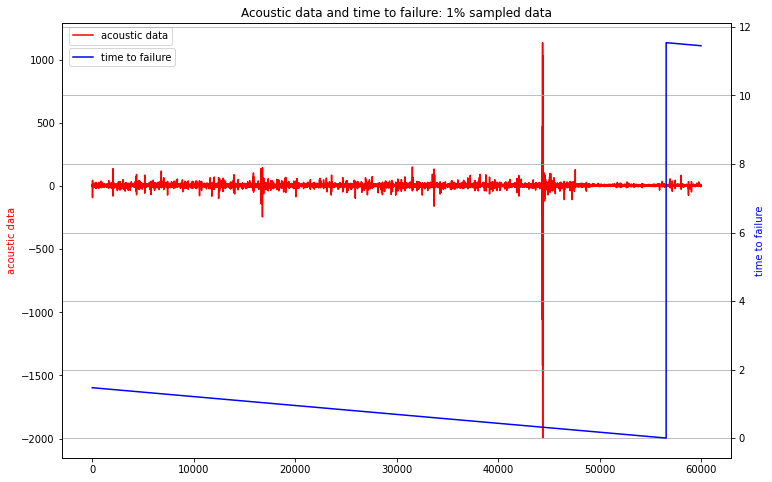

In [10]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [11]:
# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [12]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
X_train.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000
mean,4.519475157932917,6.547788190832376,-149.190941597139442,163.522288438617409,68.297997078886311,0.125830201533653,-11.224603098927293,-2.184779499404052,11.231716328963049,20.321890345649656,170.046245530393321,5.547366504438947,5.750164895071956
std,0.256049485926947,8.503939490256958,265.087983547740237,272.930331447498872,70.532565012634521,0.477901196543982,14.106851749718865,2.346558457187657,2.358067486415371,14.225526173874824,296.887014915214138,1.517037556246679,8.339211436139040
min,3.596313333333333,2.802720142449153,-5515.000000000000000,23.000000000000000,0.648601727651454,-4.091826220725587,-336.000000000000000,-39.000000000000000,9.000000000000000,11.000000000000000,23.000000000000000,4.147706666666667,2.589085218316308
25%,4.349496666666667,4.478637142151063,-154.000000000000000,92.000000000000000,28.090227382235867,-0.040779004942732,-14.000000000000000,-3.000000000000000,10.000000000000000,15.000000000000000,94.000000000000000,5.061843333333334,3.862810034013982
50%,4.522146666666667,5.618797774899163,-111.000000000000000,123.000000000000000,45.816624913747923,0.085619830683749,-10.000000000000000,-2.000000000000000,11.000000000000000,19.000000000000000,127.000000000000000,5.380853333333333,4.781513433258028
75%,4.693350000000001,6.880903553140399,-79.000000000000000,170.000000000000000,78.664201990993135,0.253930302215080,-6.000000000000000,-1.000000000000000,12.000000000000000,23.000000000000000,175.000000000000000,5.748553333333334,5.887947257796146
max,5.391993333333334,153.703569356093254,-15.000000000000000,5444.000000000000000,631.158926834507270,4.219428824355885,-2.000000000000000,0.000000000000000,50.000000000000000,337.000000000000000,5515.000000000000000,32.762073333333333,150.432368254177703


In [13]:
print("X_train size: " + str(X_train.size))
X_train.head(10)

X_train size: 54535


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4.884113333333334,5.101106130606765,-98.0,104.0,33.662481293451094,-0.024061166628209,-8.0,-2.0,11.0,18.0,104.0,5.576566666666666,4.333324673993449
1,4.725766666666667,6.588823781946801,-154.0,181.0,98.758517178736923,0.390560504371834,-11.0,-2.0,12.0,21.0,181.0,5.734166666666667,5.732776965581381
2,4.906393333333333,6.967397033524431,-106.0,140.0,33.555211406928983,0.217390561445685,-15.0,-3.0,13.0,26.0,140.0,6.152646666666667,5.895944714483795
3,4.902240000000000,6.922305187180113,-199.0,197.0,116.548171687628383,0.757277536411098,-12.0,-2.0,12.0,22.0,199.0,5.933960000000000,6.061213600190591
4,4.908720000000000,7.301110189758817,-126.0,145.0,52.977904834406473,0.064531069271374,-15.0,-2.0,12.0,26.0,145.0,6.110586666666666,6.329485313861190
5,4.913513333333333,5.434111112860393,-144.0,142.0,50.215146730160747,-0.100696595024400,-10.0,-2.0,12.0,19.0,144.0,5.695166666666666,4.608383471480033
6,4.855660000000000,5.687823395051908,-78.0,120.0,23.173004264594748,0.208809917730834,-12.0,-2.0,12.0,21.0,120.0,5.791006666666667,4.732118384640393
7,4.505426666666667,5.854511569720713,-134.0,139.0,52.388737703721112,-0.176332986628199,-11.0,-2.0,11.0,20.0,139.0,5.415000000000000,5.025125870324054
8,4.717833333333333,7.789643113079984,-156.0,168.0,65.360260986841098,-0.160166093577737,-16.0,-3.0,13.0,26.0,168.0,6.152273333333333,6.714604982530446
9,4.730960000000000,6.890459152667711,-126.0,152.0,53.760207458489305,0.150779000250290,-14.0,-3.0,12.0,23.0,152.0,5.925120000000000,5.895191091682558


In [14]:
print("y_train size: " + str(y_train.size))
y_train.head(10)

y_train size: 4195


0    1.4307971859
0    1.3914988931
0    1.3531960947
0    1.3137978019
0    1.2743995091
0    1.2360967107
0    1.1967984179
0    1.1584956195
0    1.1190973267
0    1.0796990339
dtype: float64

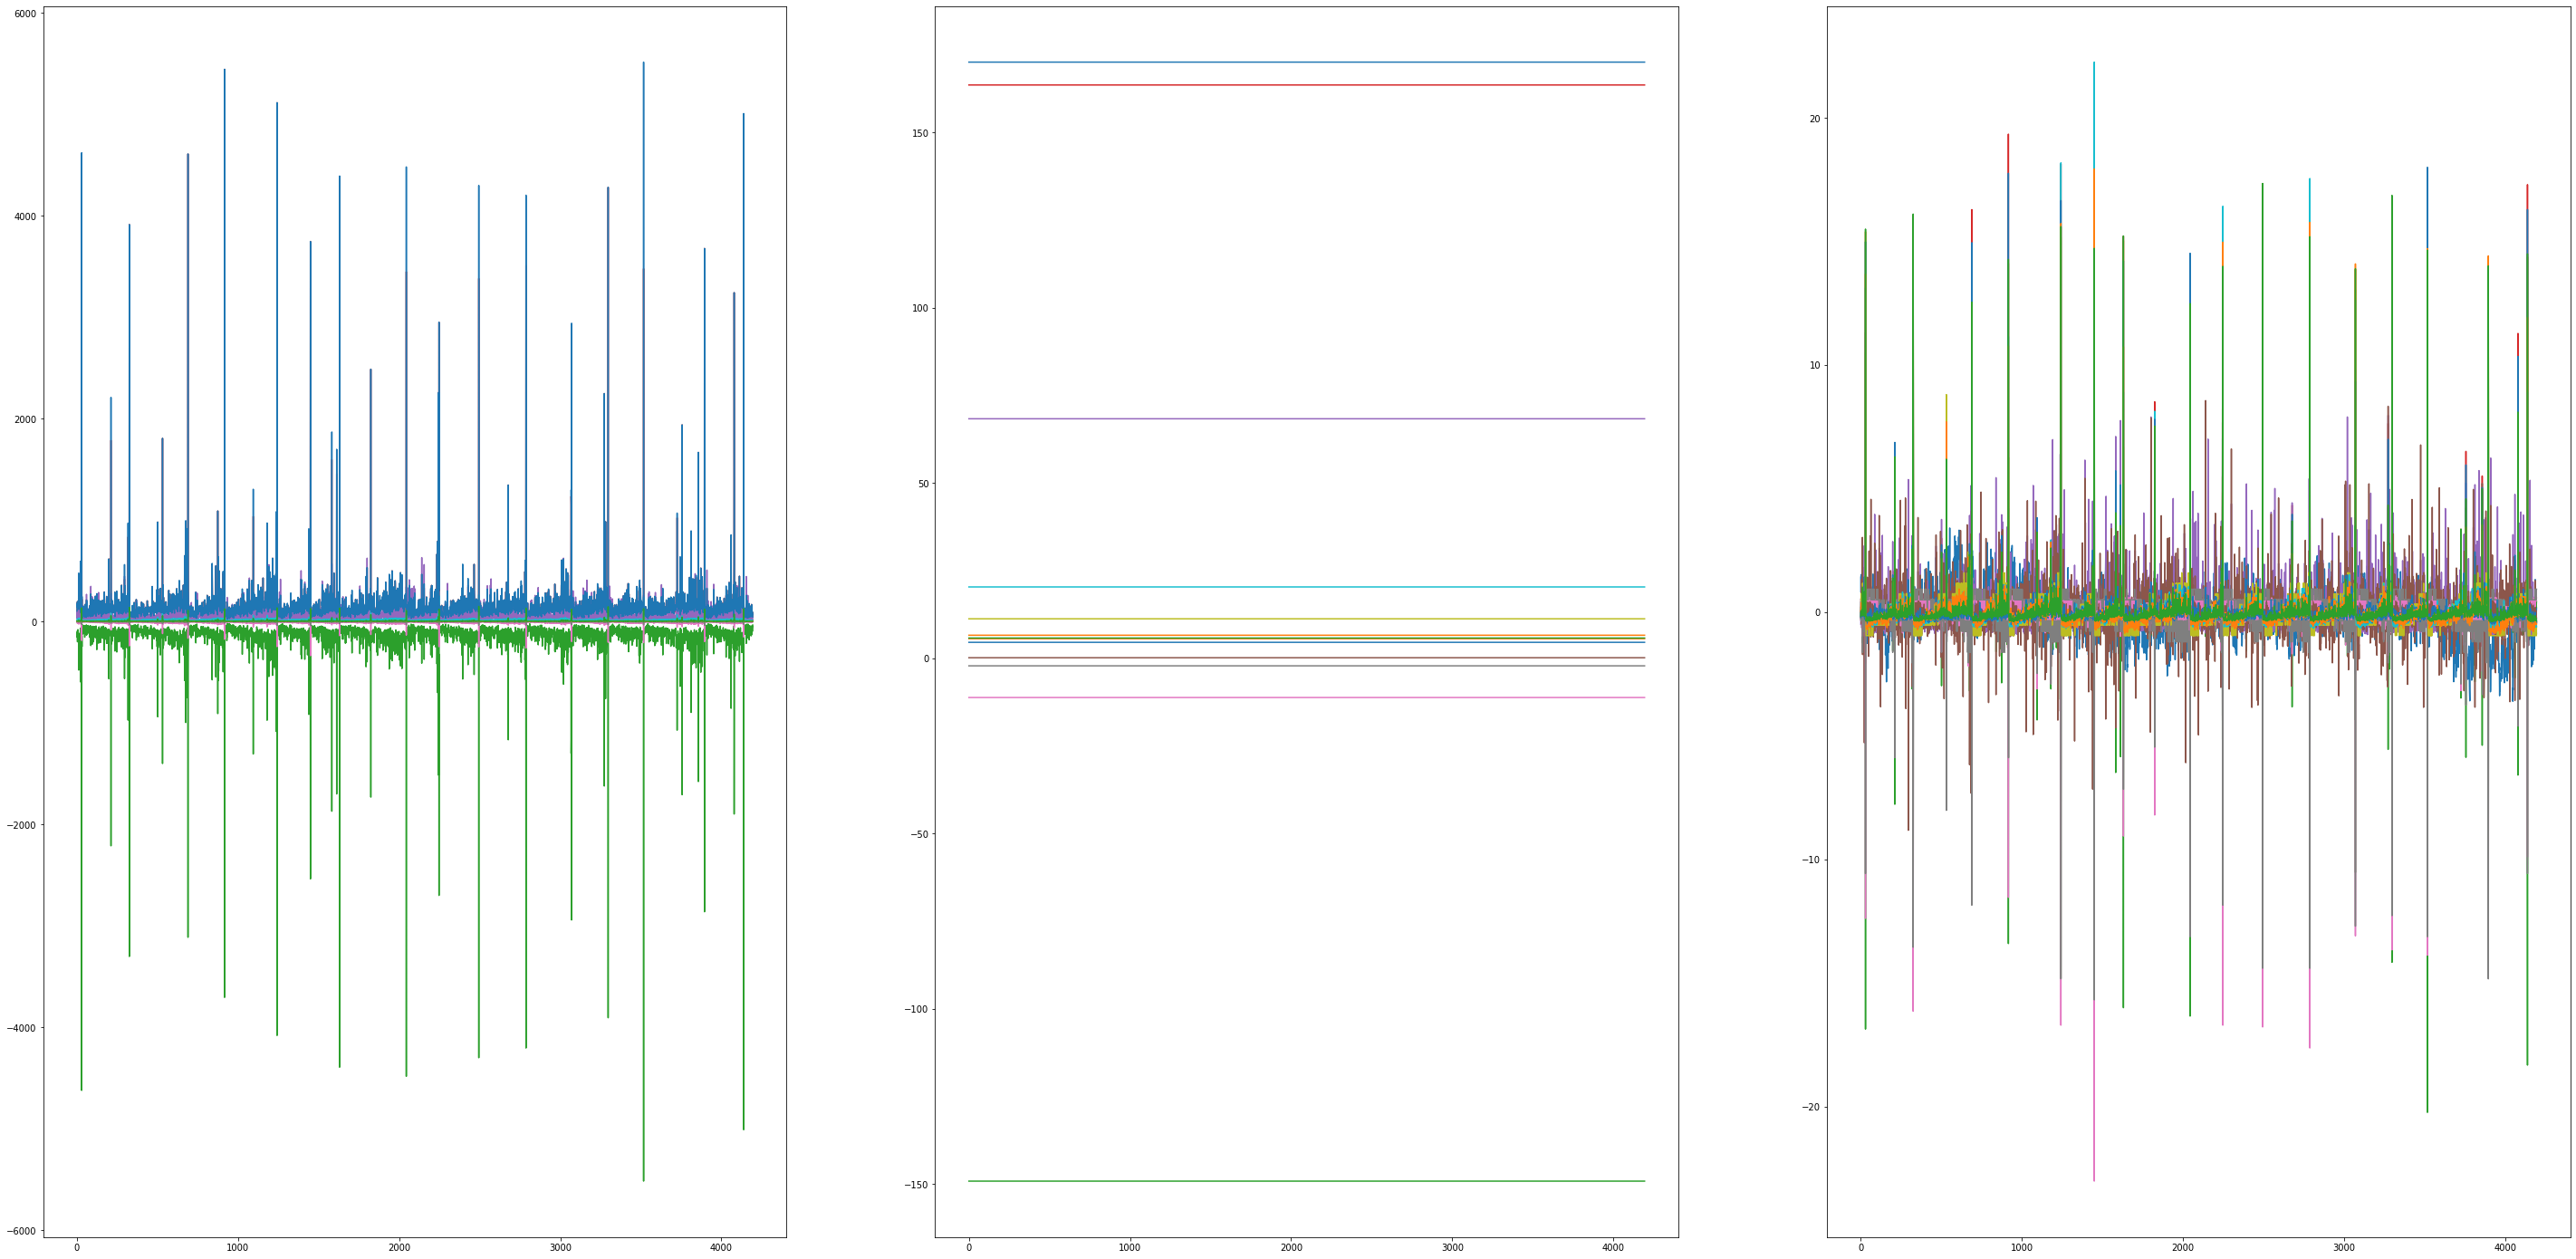

In [15]:
f = plt.figure(figsize=(50,25))
f.add_subplot(1, 3, 1)
plt.plot(X_train.values)
f.add_subplot(1, 3, 2)
plt.plot([X_train.mean()] * len(X_train))
f.add_subplot(1, 3, 3)
plt.plot(((X_train-X_train.mean())/X_train.std()).values)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

## **Adaboost regressor**

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor

parameters = [{'n_estimators':[5, 10, 20, 50, 100, 200], 'loss': ["linear", "square", "exponential"]}]

model = AdaBoostRegressor()

model_adaboostreg = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
model_adaboostreg.fit(X_train_scaled, y_train.values.flatten()) 
y_pred3 = model_adaboostreg.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(model_adaboostreg.best_score_))
print(model_adaboostreg.best_params_)

Best CV score: -2.2633
{'loss': 'exponential', 'n_estimators': 5}


In [29]:
print(y_pred3)
# mean_absolute_error
model_score = mean_absolute_error(y_train.values.flatten(), y_pred3)
print(f'Score: {model_score:0.3f}')

[5.23611433 3.93820382 2.82362183 ... 7.92655369 9.11193035 7.73737634]
Score: 2.194


## **Bagging regressor**

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor

parameters = [{'n_estimators':[10, 20, 50, 100, 200, 500]}]

model = BaggingRegressor()

model_baggreg = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
model_baggreg.fit(X_train_scaled, y_train.values.flatten()) 
y_pred4 = model_baggreg.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(model_baggreg.best_score_))
print(model_baggreg.best_params_)

Best CV score: -2.3137
{'n_estimators': 500}


In [31]:
print(y_pred4)
# mean_absolute_error
model_score = mean_absolute_error(y_train.values.flatten(), y_pred4)
print(f'Score: {model_score:0.3f}')

[2.61971223 2.08854239 2.66034408 ... 9.36191119 9.25723965 8.8544305 ]
Score: 0.804


## **SVR**

In [33]:
#Model #1 - Support Vector Machine w/ RBF + Grid Search

from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR

model = SVR(kernel='rbf', tol=0.01)
parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten()) # it takes 3 minutes to fit
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}


In [34]:
print(y_pred1)
model_score = mean_absolute_error(y_train.values.flatten(), y_pred1)
print(f'Score: {model_score:0.3f}')

[5.0946711  4.17278294 2.43113838 ... 7.63276908 9.49076648 8.39964459]
Score: 2.094


In [35]:
from sklearn.svm import NuSVR

model = NuSVR(kernel='rbf')
parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]

regNuSVR = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error')
regNuSVR.fit(X_train_scaled, y_train.values.flatten()) # it takes 3 minutes to fit
y_pred5 = regNuSVR.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(regNuSVR.best_score_))
print(regNuSVR.best_params_)

Best CV score: -2.1688
{'C': 2, 'gamma': 0.02, 'nu': 0.8}


In [36]:
print(y_pred5)
model_score = mean_absolute_error(y_train.values.flatten(), y_pred5)
print(f'Score: {model_score:0.3f}')

[5.14897614 4.27571579 2.5105736  ... 7.72849566 9.46847706 8.40819356]
Score: 2.102


## **Random forest regressor**

In [ ]:
#Model #2 - Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(criterion = 'absolute_error')
parameters = {'n_estimators':[10, 20, 50, 100]}

reg = GridSearchCV(model, parameters, cv=5)
reg.fit(X_train_scaled, y_train.values.flatten()) #it takes 14minutes to fit
y_pred = reg.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg.best_score_))
print(reg.best_params_)


Best CV score: 0.3664
{'n_estimators': 200}


In [ ]:
print(y_pred)
# mean_absolute_error
model_score = mean_absolute_error(y_train.values.flatten(), y_pred)
print(f'Score: {model_score:0.3f}')

[2.96267281 2.21028643 2.5163446  ... 9.30302191 9.719326   9.01254771]
Score: 0.815


## **Kernel Ridge Regressor**

In [ ]:
# another method is KernelRidge Regressor

from sklearn.kernel_ridge import KernelRidge

parameters = [{'gamma': np.linspace(0.001, 0.1, 10),
               'alpha': [0.005, 0.01, 0.02, 0.05, 0.1]}]

reg2 = GridSearchCV(KernelRidge(kernel='rbf'), parameters, cv=5, scoring='neg_mean_absolute_error') #neg_mean_absolute_error
reg2.fit(X_train_scaled, y_train.values.flatten()) # it takes 5 minutes to fit
y_pred2 = reg2.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg2.best_score_))
print(reg2.best_params_)

Best CV score: -2.2046
{'alpha': 0.1, 'gamma': 0.012}


In [ ]:
print(y_pred2)
# mean_absolute_error
model_score = mean_absolute_error(y_train.values.flatten(), y_pred2)
print(f'Score: {model_score:0.3f}')

[5.15135911 4.40527502 2.95736361 ... 7.90833572 9.87272368 8.64438996]
Score: 2.110


NameError: ignored

<Figure size 432x288 with 0 Axes>

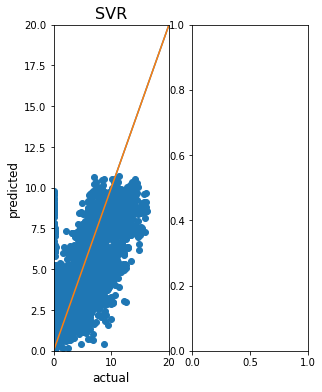

In [37]:
plt.tight_layout()
f = plt.figure(figsize=(12, 6))
f.add_subplot(1, 5, 1)
plt.scatter(y_train.values.flatten(), y_pred1)
plt.title('SVR', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot()
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

f.add_subplot(1, 5, 2)
plt.scatter(y_train.values.flatten(), y_pred2)
plt.title('Kernel Ridge', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

f.add_subplot(1, 5, 3)
plt.scatter(y_train.values.flatten(), y_pred)
plt.title('Random Forest Regressor', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

f.add_subplot(1, 5, 4)
plt.scatter(y_train.values.flatten(), y_pred3)
plt.title('Adaboost regressor', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

f.add_subplot(1, 5, 5)
plt.scatter(y_train.values.flatten(), y_pred4)
plt.title('Bagging regressor', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

# second plot
f.add_subplot(2, 3, 1)
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred1, color='orange', label='SVR')
plt.legend()
plt.title('SVR predictions vs actual')

# third plot
f.add_subplot(2, 3, 2)
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred2, color='gray', label='KernelRidge')
plt.legend()
plt.title('Kernel Ridge predictions vs actual')
# third plot
f.add_subplot(2, 3, 3)
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred, color='black', label='Random Forest Regressor')
plt.legend()
plt.title('Random Forest predictions vs actual')


In [ ]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = svm.predict(X_test_scaled)
submission.to_csv('submission.csv')